In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [3]:
df = pd.read_csv('parking_availability.csv')

In [4]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px  # Import Plotly Express for high-level plotting
from datetime import datetime
import numpy as np

# --- 1. Improved Data Parsing (Based on your code) ---

# Read CSV file
try:
    df = pd.read_csv('parking availability.csv', header=None)
except FileNotFoundError:
    print("Error: 'parking availability.csv' not found.")
    print("Please make sure the file is in the same directory as this script.")
    exit()

# Parse data
data_records = []
current_date = None
current_lot_type = None  # <-- My addition to track Structure/Surface Lot
space_type_cache = None    # <-- My addition to track Space Type (A, B, etc.)

print("Starting file parse...")

for idx, row in df.iterrows():
    # Detect a date row
    if pd.notna(row[1]) and isinstance(row[1], str) and '2025' in str(row[1]):
        try:
            date_obj = datetime.strptime(row[1], "%A, %B %d, %Y")
            current_date = date_obj.date() # Use date object
        except ValueError:
            continue
        continue # Skip to next row after finding a date

    # Detect header row
    if row[1] == 'Space Type':
        continue

    # Detect a 'group' row that defines the Lot Type
    # e.g., ",A,Structure,..." or ",A,Surface Lot,..."
    if pd.notna(row[2]) and row[2] in ['Structure', 'Surface Lot']:
        current_lot_type = row[2]
    
    # Cache the space type
    if pd.notna(row[1]) and row[1] in ['A', 'B', 'D', 'S', 'SR', 'Visitor']:
         space_type_cache = row[1]

    # Detect a data row (must have a location and a date must be set)
    if current_date and pd.notna(row[3]) and row[3] != 'Location':
        location = row[3]
        
        # Use the cached space type
        space_type = space_type_cache 
        
        if not space_type: # Skip if we haven't found a space type yet
            continue
            
        try:
            # Extract values for four time slots
            time_8am = pd.to_numeric(row[4], errors='coerce')
            time_10am = pd.to_numeric(row[5], errors='coerce')
            time_12pm = pd.to_numeric(row[6], errors='coerce')
            time_2pm = pd.to_numeric(row[7], errors='coerce')
            
            data_records.append({
                'date': current_date,
                'space_type': space_type,
                'lot_type': current_lot_type, # <-- Added the lot type
                'location': location,
                '8:00 AM': time_8am,
                '10:00 AM': time_10am,
                '12:00 PM': time_12pm,
                '2:00 PM': time_2pm
            })
        except Exception as e:
            # print(f"Skipping row {idx} due to error: {e}")
            continue

# Convert to DataFrame
data_df = pd.DataFrame(data_records)

print(f"Total records parsed: {len(data_df)}")
print(data_df.info())

# --- 2. Tidying Data for EDA ---

# "Melt" the DataFrame from wide to long ("tidy") format
# This is the key step for flexible plotting
df_tidy = data_df.melt(
    id_vars=['date', 'space_type', 'lot_type', 'location'],
    value_vars=['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM'],
    var_name='Time',
    value_name='Available Spaces'
)

# Clean up data types for better plotting
df_tidy['Available Spaces'] = pd.to_numeric(df_tidy['Available Spaces'], errors='coerce')
df_tidy = df_tidy.dropna(subset=['Available Spaces']) # Drop rows with missing data
df_tidy['Available Spaces'] = df_tidy['Available Spaces'].astype(int)
df_tidy['date'] = pd.to_datetime(df_tidy['date'])

# Add DayOfWeek column
df_tidy['DayOfWeek'] = df_tidy['date'].dt.day_name()

# Set correct order for plotting (optional but recommended)
time_order = ['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_tidy['Time'] = pd.Categorical(df_tidy['Time'], categories=time_order, ordered=True)
df_tidy['DayOfWeek'] = pd.Categorical(df_tidy['DayOfWeek'], categories=day_order, ordered=True)

print("\n--- Sample of 'Tidy' Data Ready for Plotting ---")
print(df_tidy.head())


# --- 3. EDA with Plotly Express ---

print("\n--- Generating Plots (check your browser) ---")

# Plot 1: How does parking availability change throughout the day?
# Use a violin plot to see the distribution of available spots.
fig1 = px.violin(
    df_tidy, 
    x='Time', 
    y='Available Spaces', 
    color='Time',
    box=True, # Show a box plot inside
    title='Overall Parking Availability by Time of Day'
)
fig1.show()


# Plot 2: Is it harder to park on certain days?
# We group by Day and Time and get the average, then plot
avg_by_day_time = df_tidy.groupby(['DayOfWeek', 'Time'], observed=True)['Available Spaces'].mean().reset_index()

fig2 = px.line(
    avg_by_day_time, 
    x='Time', 
    y='Available Spaces', 
    color='DayOfWeek',
    markers=True,
    title='Average Available Spaces by Day of Week and Time'
)
fig2.show()


# Plot 3: Structures vs. Surface Lots
# This uses the 'lot_type' column we added
fig3 = px.box(
    df_tidy.query("`Available Spaces` < 200"), # Query to remove large outliers for a cleaner plot
    x='Time', 
    y='Available Spaces', 
    color='lot_type',
    title='Availability: Structures vs. Surface Lots (Spaces < 200)'
)
fig3.show()


# Plot 4 & 5: What are the best and worst lots at midday?
# We'll focus on 12:00 PM as the peak busy time
midday_data = df_tidy[df_tidy['Time'] == '12:00 PM']
lot_avg = midday_data.groupby('location')['Available Spaces'].mean().sort_values()

# Top 15 Busiest Lots (Hardest to Park)
busiest_lots = lot_avg.nsmallest(15)
fig4 = px.bar(
    busiest_lots, 
    x='Available Spaces', 
    y=busiest_lots.index, 
    orientation='h',
    title='Top 15 Busiest Lots at 12:00 PM (Fewest Spaces)'
)
fig4.show()

# Top 15 Easiest Lots (Best to Park)
easiest_lots = lot_avg.nlargest(15)
fig5 = px.bar(
    easiest_lots, 
    x='Available Spaces', 
    y=easiest_lots.index, 
    orientation='h',
    title='Top 15 Easiest Lots at 12:00 PM (Most Spaces)'
)
fig5.show()


# Plot 6: Parking Inventory Treemap
# What's the total "inventory" of parking at 8:00 AM?
df_8am = df_tidy[df_tidy['Time'] == '8:00 AM'].groupby(
    ['lot_type', 'space_type', 'location'], observed=True
)['Available Spaces'].mean().reset_index()

fig6 = px.treemap(
    df_8am, 
    path=[px.Constant('All Parking'), 'lot_type', 'space_type', 'location'], 
    values='Available Spaces',
    color='Available Spaces',
    color_continuous_scale='Greens',
    title='Parking Inventory Hierarchy (Avg. Spaces at 8:00 AM)'
)
fig6.show()

print("--- All plots generated. ---")

Error: 'parking availability.csv' not found.
Please make sure the file is in the same directory as this script.
Starting file parse...
Total records parsed: 1306
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1306 non-null   object 
 1   space_type  1306 non-null   object 
 2   lot_type    1306 non-null   object 
 3   location    1306 non-null   object 
 4   8:00 AM     1285 non-null   float64
 5   10:00 AM    1285 non-null   float64
 6   12:00 PM    1285 non-null   float64
 7   2:00 PM     1285 non-null   float64
dtypes: float64(4), object(4)
memory usage: 81.8+ KB
None

--- Sample of 'Tidy' Data Ready for Plotting ---
        date space_type   lot_type           location     Time  \
0 2025-09-25          A  Structure               8980  8:00 AM   
1 2025-09-25          A  Structure             Athena  8:00 AM   
2 2025-09-25    

/var/folders/p4/4sw9swv12vd7n6f5q9xx9znh0000gn/T/ipykernel_52164/97999437.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notna(row[1]) and isinstance(row[1], str) and '2025' in str(row[1]):
/var/folders/p4/4sw9swv12vd7n6f5q9xx9znh0000gn/T/ipykernel_52164/97999437.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  date_obj = datetime.strptime(row[1], "%A, %B %d, %Y")
/var/folders/p4/4sw9swv12vd7n6f5q9xx9znh0000gn/T/ipykernel_52164/97999437.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

--- All plots generated. ---


Data parsing and tidying complete.
Generating 'A' vs. 'B' comparison plot...
Plot saved as 'A_vs_B_comparison.png'


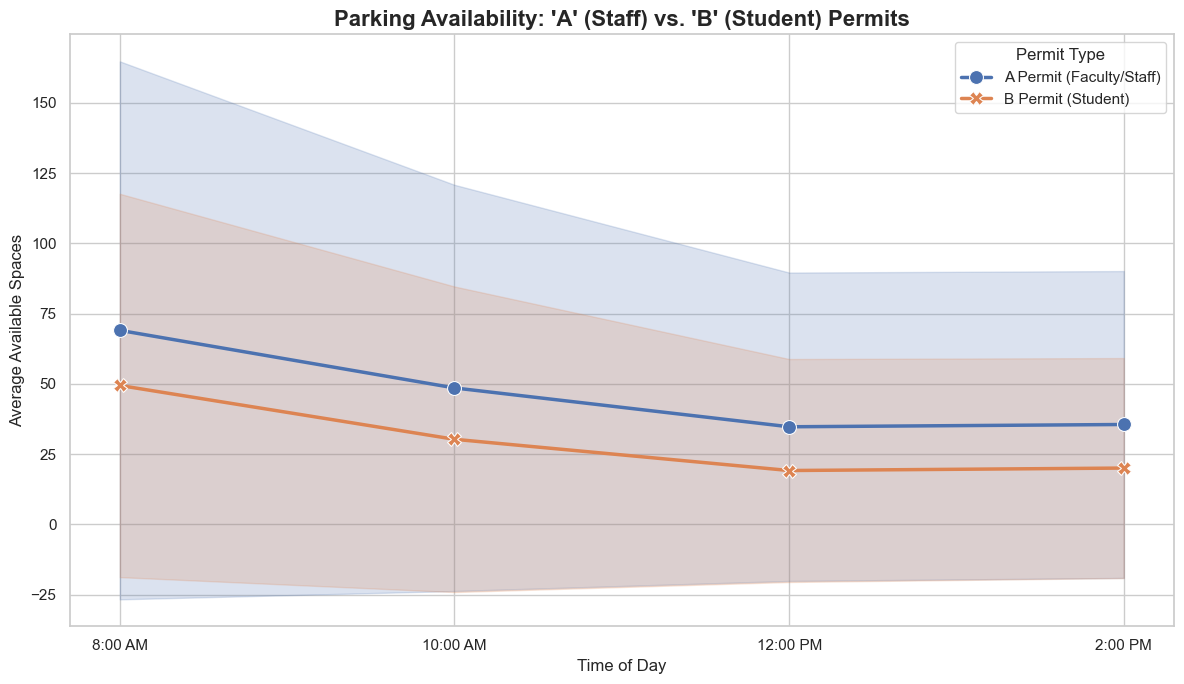

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import re
from datetime import datetime

# ------------------------------------------------------------------
# 2. PARSING FUNCTION
# ------------------------------------------------------------------
def parse_parking_data(filepath='parking_availability.csv'):
    """
    Parses the multi-header, multi-block parking CSV file into a single,
    clean and tidy DataFrame.
    """
    all_data_frames = []
    current_week = ""
    current_date = None
    header_cols = []
    data_lines = []
    
    # Regex to find the date line, e.g., ,"Thursday, September 25, 2025",...
    date_pattern = re.compile(r',"(.*?,\s\w+\s\d+,\s\d{4})"')
    
    try:
        with open(filepath, 'r') as f:
            for line in f:
                # 1. Find the Week Header
                if line.startswith('Parking Occupancy'):
                    # If we find a new "Week" block, process the data we've collected
                    if data_lines:
                        day_data = io.StringIO('\n'.join(data_lines))
                        df_day = pd.read_csv(day_data, header=None, names=header_cols)
                        df_day['Date'] = current_date
                        df_day['Week'] = current_week
                        all_data_frames.append(df_day)
                    
                    # Reset for the new block
                    current_week = line.split(',')[0].split(':', 1)[1].strip()
                    data_lines = []
                    continue

                # 2. Find the Date Header
                match = date_pattern.search(line)
                if match:
                    # Process the previous day's data if it exists
                    if data_lines:
                        day_data = io.StringIO('\n'.join(data_lines))
                        df_day = pd.read_csv(day_data, header=None, names=header_cols)
                        df_day['Date'] = current_date
                        df_day['Week'] = current_week
                        all_data_frames.append(df_day)
                    
                    # Reset data lines and set new date
                    data_lines = []
                    current_date = pd.to_datetime(match.group(1))
                    continue

                # 3. Find the main column header
                if 'Space Type' in line and 'Location' in line:
                    # Clean up the header line (handles the rogue backtick)
                    clean_line = line.replace('`', '').strip()
                    header_cols = [h.strip() if h.strip() else f'Unnamed:{i}' for i, h in enumerate(clean_line.split(','))]
                    continue
                
                # 4. If it's a data line, add it
                if current_date and header_cols and line.strip().strip(','):
                    data_lines.append(line)

            # Process the very last block of data
            if data_lines:
                day_data = io.StringIO('\n'.join(data_lines))
                df_day = pd.read_csv(day_data, header=None, names=header_cols)
                df_day['Date'] = current_date
                df_day['Week'] = current_week
                all_data_frames.append(df_day)

    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please make sure it's in the same directory as this script.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred during parsing: {e}")
        return pd.DataFrame()

    # Combine all daily DataFrames into one
    if not all_data_frames:
        print("Error: No data was parsed. Check file format.")
        return pd.DataFrame()

    df = pd.concat(all_data_frames, ignore_index=True)

    # --- 5. Data Cleaning & Tidying ---

    # Rename columns for clarity
    df = df.rename(columns={
        'Unnamed:1': 'Space Type',
        'Unnamed:2': 'Lot Type',  # Structure or Surface Lot
        'Unnamed:3': 'Location'
    })

    # Forward-fill the 'Space Type' and 'Lot Type'
    df['Space Type'] = df['Space Type'].ffill()
    df['Lot Type'] = df['Lot Type'].ffill()
    
    # Drop rows that are just headers or all-empty
    df = df.dropna(subset=['Location'])
    df = df[df['Location'] != 'Location']

    # "Melt" the DataFrame from wide to long format for easy plotting
    time_cols = ['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']
    df_long = pd.melt(df, 
                      id_vars=['Week', 'Date', 'Space Type', 'Lot Type', 'Location'], 
                      value_vars=time_cols,
                      var_name='Time', 
                      value_name='Available Spaces')

    # Convert data types
    df_long['Available Spaces'] = pd.to_numeric(df_long['Available Spaces'], errors='coerce')
    df_long = df_long.dropna(subset=['Available Spaces'])
    df_long['Available Spaces'] = df_long['Available Spaces'].astype(int)
    
    # Add a 'Day of Week' column
    df_long['DayOfWeek'] = df_long['Date'].dt.day_name()
    
    # Set correct categorical order for plotting
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    df_long['DayOfWeek'] = pd.Categorical(df_long['DayOfWeek'], categories=day_order, ordered=True)
    
    time_order = ['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']
    df_long['Time'] = pd.Categorical(df_long['Time'], categories=time_order, ordered=True)

    print("Data parsing and tidying complete.")
    return df_long

# ------------------------------------------------------------------
# 3. MAIN ANALYSIS BLOCK (ADDRESSING RESEARCH QUESTION 1)
# ------------------------------------------------------------------
if __name__ == "__main__":
    
    # 1. Parse the data from the CSV file
    df_tidy = parse_parking_data('parking_availability.csv')
    
    if not df_tidy.empty:
        # 2. Filter for only 'A' and 'B' permit types
        df_permits = df_tidy[df_tidy['Space Type'].isin(['A', 'B'])].copy()
        
        # Rename for a cleaner plot legend
        df_permits['Space Type'] = df_permits['Space Type'].map({
            'A': 'A Permit (Faculty/Staff)',
            'B': 'B Permit (Student)'
        })

        print("Generating 'A' vs. 'B' comparison plot...")

        # 3. Create the plot
        plt.figure(figsize=(12, 7))
        sns.set_theme(style="whitegrid")
        
        # Use a pointplot or lineplot to show the trend and confidence interval
        ax = sns.lineplot(
            data=df_permits,
            x='Time',
            y='Available Spaces',
            hue='Space Type',
            style='Space Type',
            markers=True,
            dashes=False,
            markersize=10,
            linewidth=2.5,
            errorbar='sd'  # Show standard deviation as error bars
        )
        
        # 4. Finalize and save the plot
        ax.set_title("Parking Availability: 'A' (Staff) vs. 'B' (Student) Permits", fontsize=16, weight='bold')
        ax.set_xlabel("Time of Day", fontsize=12)
        ax.set_ylabel("Average Available Spaces", fontsize=12)
        plt.legend(title='Permit Type')
        
        plt.tight_layout()
        plt.savefig('A_vs_B_comparison.png')
        print("Plot saved as 'A_vs_B_comparison.png'")
        
        plt.show()

<Figure size 1000x600 with 0 Axes>

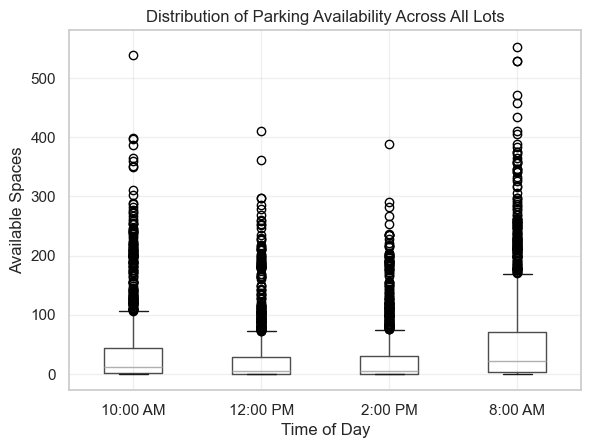

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load the file
# -------------------------------
df = pd.read_csv("parking_availability.csv")

# -------------------------------
# 2. Fix the header row problems
# -------------------------------
# The real header is in row 1 (index 1)
df.columns = df.iloc[1]

# Drop the top junk header rows
df = df.drop([0, 1]).reset_index(drop=True)

# -------------------------------
# 3. Keep only the useful columns
# -------------------------------
df = df[['Space Type', 'Location', '8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']]

# Rename for convenience
df = df.rename(columns={
    'Space Type': 'permit_type',
    'Location': 'lot'
})

# Convert numeric columns
time_cols = ['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']
df[time_cols] = df[time_cols].apply(pd.to_numeric, errors='coerce')

# -------------------------------
# 4. Melt (wide → long)
# -------------------------------
df_long = df.melt(
    id_vars=['permit_type', 'lot'],
    value_vars=time_cols,
    var_name='time',
    value_name='available'
)

# Drop empty rows (Visitor lots often have NaN availability)
df_long = df_long.dropna(subset=['available'])

# -------------------------------
# 5. Plot the distribution
# -------------------------------
plt.figure(figsize=(10, 6))
df_long.boxplot(column='available', by='time')

plt.title("Distribution of Parking Availability Across All Lots")
plt.suptitle("")  # Removes Pandas extra title
plt.xlabel("Time of Day")
plt.ylabel("Available Spaces")
plt.grid(True, alpha=0.3)
plt.show()


In [3]:
df

1,permit_type,lot,8:00 AM,10:00 AM,12:00 PM,2:00 PM
0,A,8980,25.0,23.0,19.0,20.0
1,A,Athena,217.0,140.0,108.0,112.0
2,A,Campus Point East,94.0,23.0,13.0,17.0
3,A,Campus Point West,1.0,0.0,0.0,1.0
4,A,Gilman,326.0,120.0,44.0,45.0
...,...,...,...,...,...,...
1334,Visitor,P510,4.0,2.0,0.0,0.0
1335,Visitor,P602,7.0,7.0,3.0,0.0
1336,Visitor,P603,21.0,17.0,10.0,26.0
1337,Visitor,P703,11.0,9.0,12.0,13.0


In [21]:
df[df['lot'] == 'P002']

1,permit_type,lot,8:00 AM,10:00 AM,12:00 PM,2:00 PM
35,B,P002,23.0,7.0,0.0,0.0
148,B,P002,21.0,6.0,0.0,2.0
262,B,P002,28.0,20.0,14.0,2.0
376,B,P002,23.0,23.0,4.0,5.0
490,B,P002,25.0,18.0,13.0,8.0
601,B,P002,26.0,17.0,10.0,17.0
712,B,P002,27.0,24.0,13.0,18.0
823,B,P002,31.0,25.0,25.0,21.0
934,B,P002,21.0,19.0,12.0,4.0
1045,B,P002,53.0,21.0,0.0,0.0


In [22]:
import requests
import pandas as pd

# 1. URL of the JSON/GeoJSON you found in Step 6 above
json_url = "https://maps.ucsd.edu/api/parking-lots-features.json"

resp = requests.get(json_url)
data = resp.json()

records = []
for feat in data['features']:
    props = feat['properties']
    geom = feat['geometry']
    if props.get('category') == 'parking':
        lot_name = props.get('name')
        coords = geom['coordinates']
        lon, lat = coords[0], coords[1]
        records.append({
            'lot': lot_name,
            'latitude': lat,
            'longitude': lon
        })

lot_coords = pd.DataFrame(records)
lot_coords.to_csv("lot_coordinates.csv", index=False)
print("Saved coords for", len(lot_coords), "lots")


JSONDecodeError: Expecting value: line 1 column 1 (char 0)